In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib.E15Analyzer import E15Analyzer
from lib.Plots.CirclesHeatmap import CirclesHeatmap
from lib.RFacade import RFacade
from lib.plot_utils import *
from lib.utils import *



import pandas..
importing path functions...
importing stat functions...
ipdb is not installed and cannot be imported...
importing misc functions..
importing done...
importing plot functions...


In [3]:
expr = E15Analyzer.get_expr_values(tophat=True, basedir='../data/20180516_rna_tophat')
print (expr.shape)



(207285, 11)


In [4]:

n_genes = 5000 #  # 2000 # 5000
padj_thr = None # 0.05 # 1e-15  # 0.0001
ensembl_gene_ids = set()
if n_genes != None:
    expr = expr.sort_values('padj')
    ensembl_gene_ids = set()
    for ri, r in expr.iterrows():
        ensembl_gene_ids.add(r['ensembl_gene_id'])
        if len(ensembl_gene_ids) == n_genes:
            break
else:
    ensembl_gene_ids = set(expr[expr['padj'] < padj_thr]['ensembl_gene_id'])
    n_genes = len(ensembl_gene_ids)


In [5]:
expr = expr[expr['ensembl_gene_id'].isin(ensembl_gene_ids)]
expr = expr.pivot('ensembl_gene_id', 'treatment', 'log2FoldChange')


In [6]:
expr.shape

(5000, 9)

In [7]:
expr.shape

(5000, 9)

In [8]:
rscripts_dir='/mnt/znas/icb_zstore01/groups/ml01/workspace/ignacio.ibarra/wild/lib/rscripts'

In [9]:
import rpy2

In [10]:

# new_cols = [treatment + "_" + time for treatment in ['KCl', 'bdnf', 'forskolin'] for time in ['1h', '6h', '10h']]
new_cols = [treatment + "_" + time for treatment in ['KCl', 'bdnf'] for time in ['1h', '6h', '10h']]

expr = expr[[c for c in new_cols if c in expr]]

expr_rowZscores = expr.sub(expr.mean(axis=1), axis=0).divide(expr.std(axis=1), axis=0)
stab_output_path = "../data/expr_metrics_by_clusters_NGENES%i" % (n_genes) + ".tsv.gz"
print(stab_output_path)
if not exists(stab_output_path):
    print(stab_output_path)
    # assert False
    # stab = RFacade.get_clustering_stability_measures(expr_rowZscores, 20, rscripts_dir=rscripts_dir)
    DataFrameAnalyzer.to_tsv_gz(stab, stab_output_path, index=True)
stab = DataFrameAnalyzer.read_tsv_gz(stab_output_path, index_col=0)
print(stab)


../data/expr_metrics_by_clusters_NGENES5000.tsv.gz
                   Score        Method  Clusters
Connectivity  442.049206  hierarchical         2
Dunn            0.096220  hierarchical         2
Silhouette      0.306604        kmeans         2
APN             0.088751           pam         2
AD              2.110515        kmeans        20
ADM             0.327047        kmeans         4
FOM             0.585169           pam        20


In [11]:
expr_rowZscores.head(5)

treatment             KCl_1h    KCl_6h   KCl_10h   bdnf_1h   bdnf_6h  bdnf_10h
ensembl_gene_id                                                               
ENSMUSG00000000001 -0.344854  0.336881 -0.611639  1.872058 -0.854884 -0.397562
ENSMUSG00000000031  0.748287 -1.167366 -1.275122  0.961137  0.726332  0.006733
ENSMUSG00000000058 -0.537523  0.407481  1.796884 -0.410442 -1.051581 -0.204819
ENSMUSG00000000078 -0.523578  0.441844  0.729095  1.316669 -1.392342 -0.571687
ENSMUSG00000000088 -1.336542  1.387090 -0.302069 -0.792388  0.408731  0.635179

In [12]:
import pickle

In [13]:
df = []
for k in range(2, 20):
    bkp_path = 'pam_bkp_%i.pkl' % k
    if not exists(bkp_path):
        stab = RFacade.get_clustering_stability_measures(expr_rowZscores, k, k, rscripts_dir=rscripts_dir)
        pickle.dump(stab, open(bkp_path, 'wb'))
    df.append(pickle.load(open(bkp_path,'rb')))
df = pd.concat(df)

In [14]:
%matplotlib inline

In [ ]:
df

Score Method Clusters
Connectivity  324.585714    pam        2
Dunn            0.022239    pam        2
Silhouette      0.342838    pam        2
APN             0.084543    pam        2
AD              2.397350    pam        2
...                  ...    ...      ...
Silhouette      0.184145    pam       19
APN             0.505007    pam       19
AD              1.407938    pam       19
ADM             0.701716    pam       19
FOM             0.505858    pam       19

[126 rows x 3 columns]

7
0 Dunn
1 APN
2 FOM
3 ADM
4 Connectivity
5 Silhouette
6 AD


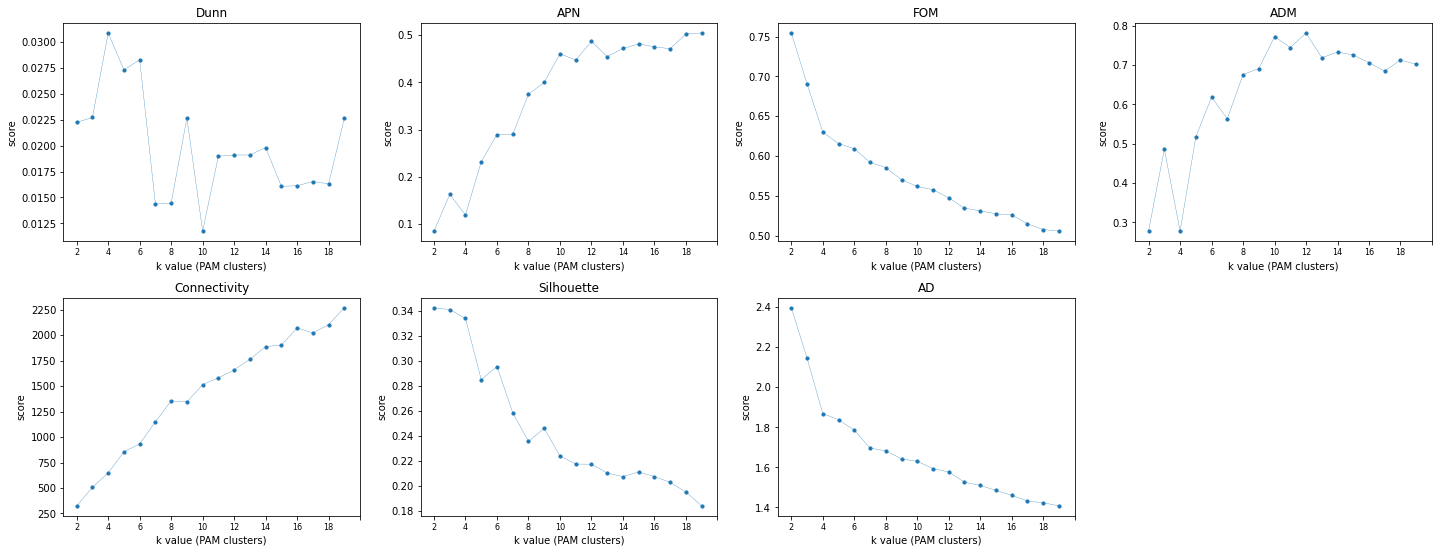

In [47]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 15
metrics = set(df.index)
print(len(metrics))
for mi, m in enumerate(metrics):
    print(mi, m)
    # if m != 'Silhouette':
    #     continue
    plt.subplot(4, 4, mi + 1)
    plt.plot(df[df.index == m]['Clusters'], df[df.index == m]['Score'], lw=.3);
    plt.scatter(df[df.index == m]['Clusters'], df[df.index == m]['Score'], s=10);
    
    
    plt.title(m)
    plt.ylabel('score')
    plt.xlabel('k value (PAM clusters)')
    plt.xticks([i for i in range(20) if i % 2 == 0], fontsize=8)
plt.tight_layout()
plt.show()

## Elbow method.

In [37]:
# pseudo code for an elbow plot based on k-measns
# attempt for an elbow plot
from sklearn.cluster import KMeans

distortions = []
K = range(1,20)
for k in K:
    print(k)
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(expr_rowZscores)
    distortions.append(kmeanModel.inertia_)
    print(pd.Series(kmeanModel.labels_).value_counts())
    print('')

1
0    5000
dtype: int64

2
0    2592
1    2408
dtype: int64

3
1    1918
2    1762
0    1320
dtype: int64

4
3    1500
2    1386
1    1152
0     962
dtype: int64

5
4    1441
0    1305
2    1021
3     782
1     451
dtype: int64

6
3    1265
2     932
1     897
5     853
4     637
0     416
dtype: int64

7
1    928
2    917
6    815
3    748
4    598
5    588
0    406
dtype: int64

8
6    916
1    913
0    684
3    660
4    560
7    484
2    424
5    359
dtype: int64

9
2    897
5    717
3    662
8    552
1    528
7    474
4    413
6    397
0    360
dtype: int64

10
2    819
4    632
1    608
9    559
5    496
0    465
7    404
8    384
6    350
3    283
dtype: int64

11
9     815
8     620
5     562
1     535
10    471
0     440
6     400
3     352
4     292
7     267
2     246
dtype: int64

12
9     690
10    535
11    530
5     491
0     476
3     470
4     379
7     357
2     327
1     274
8     237
6     234
dtype: int64

13
4     540
6     524
8     513
7     489
1     484
3     

3     405
12    387
16    386
1     383
7     296
4     278
5     275
14    258
2     257
15    242
13    234
8     233
10    223
0     216
18    208
9     190
6     184
11    173
17    172
dtype: int64

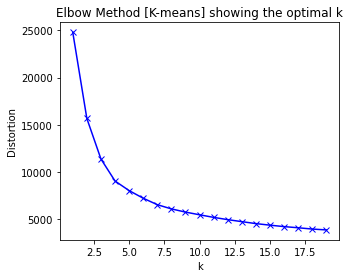

In [25]:
plt.figure(figsize=(5,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method [K-means] showing the optimal k')
plt.show()

In [23]:
stab

Score        Method  Clusters
Connectivity  442.049206  hierarchical         2
Dunn            0.096220  hierarchical         2
Silhouette      0.306604        kmeans         2
APN             0.088751           pam         2
AD              2.110515        kmeans        20
ADM             0.327047        kmeans         4
FOM             0.585169           pam        20

In [34]:

# the optimal number of clusters for PAM is selected
n_optimal_clusters = 20 # 8

clusters = RFacade.get_pam_clustering(expr_rowZscores, n_optimal_clusters, kmin=n_optimal_clusters, rscripts_dir=rscripts_dir)
clusters['ensembl_gene_id'] = expr.index
from lib.MyGeneAnalyzer import MyGeneAnalyzer
for cluster_id, grp in clusters.groupby('n.' + str(n_optimal_clusters)):
    print(grp.shape)
    symbol_by_ensembl = MyGeneAnalyzer.get_symbol_by_ensembl(grp['ensembl_gene_id'], species='mouse')
    grp['symbol'] = grp['ensembl_gene_id'].map(symbol_by_ensembl)
    DataFrameAnalyzer.to_tsv_gz(grp[['symbol']], '/tmp/' + str(cluster_id) + ".tsv.gz")

# describe clusters by a set of Z-scores
table = []
for cluster_id, grp in clusters.groupby('n.' + str(n_optimal_clusters)):
    print(cluster_id)
    sel = expr_rowZscores[expr_rowZscores.index.isin(set(grp['ensembl_gene_id']))]
    next = (sel.mean() - average(sel.mean()))/ sel.std()
    table.append(list(next))
res = pd.DataFrame(table, columns=expr_rowZscores.columns)
for c in res:
    print(c)
    print(res.sort_values(c, ascending=False))

print(res)


R[write to console]: Error in library(ppclust) : there is no package called ‘ppclust’



pam clustering...


RRuntimeError: Error in library(ppclust) : there is no package called ‘ppclust’


In [ ]:

vmax = 3.5
for c in clusters.columns[1:-1]:
    print c
    nk = int(c.split(".")[1])
    print c, nk
    # invert clusters positions to fit the 8 clusters grouping
    if n_optimal_clusters == 8:
        new_clusters = {1: 2, 2: 5, 3: 4, 4: 1, 5: 3, 6: 6, 7: 8, 8: 7} #  {2: 4, 3: 3, 4: 1, 5: 4, 6: 5, 7: 4, 8: 2}
        clusters['new.k'] = clusters[c].map(new_clusters)
        clusters = clusters.sort_values('new.k')
    else:
        clusters = clusters.sort_values(c)

    expr_rowZscores = expr_rowZscores.reindex(clusters['ensembl_gene_id'])

    print expr_rowZscores.head()
    sns.heatmap(expr_rowZscores.reindex(expr_rowZscores.index), cmap='RdBu_r', vmin=-vmax , vmax=vmax, yticklabels=False)

    genes_by_group = {}
    for ri, r in clusters.iterrows():
        if not r[c] in genes_by_group:
            genes_by_group[r[c]] = set()
        genes_by_group[r[c]].add(r['ensembl_gene_id'])


    plt.tight_layout()
    savepng('/tmp/' + c)
    plt.close()

    k_by_ensembl = DataFrameAnalyzer.get_dict(clusters, 'ensembl_gene_id', 'new.k' if n_optimal_clusters == 8 else c)
    expr_rowZscores['ensembl'] = expr_rowZscores.index
    expr_rowZscores['k'] = expr_rowZscores['ensembl'].map(k_by_ensembl)
    symbol_by_ensembl = MyGeneAnalyzer.get_symbol_by_ensembl(expr_rowZscores['ensembl'], species='mouse')
    expr_rowZscores['symbol'] = expr_rowZscores['ensembl'].map(symbol_by_ensembl)

# enrichments by clusters
go = []
bg = ensembl_gene_ids
for nk in range(1, n_optimal_clusters + 1):
    fg = set(clusters[clusters['new.k'] == nk]['ensembl_gene_id'])
    next_bg = bg - fg
    print len(fg), len(next_bg)
    next_go = RFacade.run_topGO(fg, next_bg)[0]
    next_go['k'] = nk
    go.append(next_go)
go = pd.concat(go)
go['Fisher.elim'] = go['Fisher.elim'].astype(float)
sig_go = set(go[go['Fisher.elim'] < 0.05]['GO.ID'])
sig_go = go[go['GO.ID'].isin(sig_go)]

for ont_type, grp in sig_go.groupby('ont.type'):
    print ont_type
    print grp.shape
    grp['minus.log.padj'] = -np.log10(grp['Fisher.elim'])
    grp["go.id"] = grp['GO.ID'] + ", " + grp['Term']
    hm = grp.pivot('go.id', 'k', 'minus.log.padj')
    odd_ratio = grp.pivot('go.id', 'k', 'odd.ratio')
    hm['max'] = hm.max(axis=1)
    hm = hm.sort_values('max', ascending=False)
    odd_ratio = odd_ratio.reindex(hm.index)
    hm = hm.head(20)
    odd_ratio = odd_ratio.head(20)
    print hm
    del hm['max']

    odd_ratio = odd_ratio.reindex(odd_ratio.index[::-1])
    hm = hm.reindex(hm.index[::-1])

    hm.index = [" ".join(k.split(" ")[1:]) for k in hm.index]
    odd_ratio.index = [" ".join(k.split(" ")[1:]) for k in odd_ratio.index]

    CirclesHeatmap.make_bubble_heatmap(odd_ratio, hm, marker='o', palette_id='Greens',
                                       circle_legend_ticks=[1, 5, 10], quantAmplifier=3,
                                       cbar_label='Odds ratio', tickscolorbar=[1, 3, 5, 7], vmin=0, vmax=8,
                                       grid=False, rowspan=3, title=ont_type, circles_legend_title='-log(p.adj)',
                                       heatmap_title=ont_type, xlab='cluster', ylab='GO:ID')

    plt.subplots_adjust(left=0.5)
    savepdf("/tmp/" + ont_type)
    plt.close()
